In [3]:
import time
import random 
import unicodedata
import string 
import re

import matplotlib.pyplot as plt 
import torch

torch.backends.cudnn.deterministic = True

In [93]:
# General Settings 
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED) 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEXT_PORTION_SIZE = 200 
NUM_ITER = 5_000 
LEARNING_RATE = 0.005
EMBEDDING_DIM = 100 
HIDDEN_DIM = 128 

print(f"Device: {DEVICE}")

Device: cpu


In [11]:
# Dataset 
with open("data/anna.txt", "r") as f: 
    textfile = f.read() 

# Strip extra spaces 
textfile = re.sub(" +", " ", textfile)

TEXT_LENGTH = len(textfile) 
print(f"Number of chars in text: {TEXT_LENGTH}")

Number of chars in text: 1984768


In [12]:
TEXT_LENGTH - TEXT_PORTION_SIZE

1984568

In [15]:
# Divide the text into similar portions 

def random_portion(textfile): 
    # choose a rand int btween 0 and tot. number of chars in df - text_portion_size
    start_index = random.randint(0, TEXT_LENGTH - TEXT_PORTION_SIZE)
    # from start_idx add the text_portion_size + 1 to get the end_indx
    end_index = start_index + TEXT_PORTION_SIZE + 1
    return textfile[start_index:end_index]

print(random_portion(textfile))

sort of tragedy. 'I'm much obliged for the
gratification, my humble respects'--that's all the tragedy. And in
platonic love there can be no tragedy, because in that love all is clear
and pure, because.


In [23]:
# Convert Chars to Tensors
def char_to_tensor(text) -> torch.tensor: 
    _list = [string.printable.index(c) for c in text]
    tensor = torch.tensor(_list).long()
    return tensor

print(string.printable)
print(char_to_tensor("01abc"))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

tensor([ 0,  1, 10, 11, 12])


In [27]:
def draw_random_sample(textfile): 
    text_long = char_to_tensor(random_portion(textfile))
    inputs = text_long[:-1]
    targets = text_long[1:]
    return inputs, targets

print(draw_random_sample(textfile))

(tensor([94, 36, 21, 14, 33, 14, 34, 94, 36, 21, 14, 33, 10, 23, 13, 27, 24, 31,
        18, 29, 12, 17, 73, 96, 27, 14, 10, 13, 34, 94, 15, 24, 27, 94, 17, 18,
        28, 94, 28, 25, 14, 14, 12, 17, 73, 94, 28, 29, 24, 24, 13, 94, 12, 24,
        22, 25, 27, 14, 28, 28, 18, 23, 16, 94, 17, 18, 28, 94, 12, 27, 24, 28,
        28, 14, 13, 94, 15, 18, 23, 16, 14, 27, 28, 73, 94, 32, 10, 18, 29, 18,
        23, 16, 94, 29, 24, 96, 28, 14, 14, 94, 18, 15, 94, 29, 17, 14, 94, 12,
        27, 10, 12, 20, 94, 32, 24, 30, 21, 13, 94, 23, 24, 29, 94, 12, 24, 22,
        14, 94, 10, 16, 10, 18, 23, 75, 94, 50, 23, 14, 94, 19, 24, 18, 23, 29,
        94, 12, 27, 10, 12, 20, 14, 13, 75, 96, 96, 36, 21, 27, 14, 10, 13, 34,
        73, 94, 15, 27, 24, 22, 94, 29, 17, 14, 94, 28, 24, 30, 23, 13, 94, 24,
        15, 94, 21, 18, 16, 17, 29, 94, 28, 29, 14, 25, 28, 94, 24, 23, 94, 29,
        17, 14]), tensor([36, 21, 14, 33, 14, 34, 94, 36, 21, 14, 33, 10, 23, 13, 27, 24, 31, 18,
        29, 12, 17, 7

In [32]:
# Model 

class RNN(torch.nn.Module): 
    def __init__(
        self, 
        input_size: int, 
        embed_size: int, 
        hidden_size: int, 
        output_size: int
        ): 
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(
                                    num_embeddings=input_size, 
                                    embedding_dim=embed_size) 
        self.rnn = torch.nn.LSTMCell(input_size=embed_size, 
                                     hidden_size=hidden_size) 
        self.fc = torch.nn.Linear(hidden_size, output_size) 
        
    def forward(self, character, hidden_state, cell_state):
        # expects character as size (batch_size, 1) 
        
        # (batch_size, embedding_dim) = (1, embedding_dim=100) 
        embedded = self.embed(character) # (1 * 100)
        (hidden_state, cell_state) = self.rnn(embedded, (hidden_state, cell_state))
        output = self.fc(hidden_state)
        return output, hidden_state, cell_state
                                              
    def init_zero_state(self):
        # dimension = (1 x 128)
        init_hidden = torch.zeros(1, self.hidden_size).to(DEVICE) 
        init_cell = torch.zeros(1, self.hidden_size).to(DEVICE)
        return (init_hidden, init_cell)
                                                                                    
                                              
        

In [96]:
torch.manual_seed(RANDOM_SEED) 
model = RNN(input_size=len(string.printable), # 100
            embed_size=EMBEDDING_DIM,         # 100
            hidden_size=HIDDEN_DIM,           # 128
            output_size=len(string.printable) # 100
           ) 
model = model.to(DEVICE) 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 

In [89]:
# Training 

def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    ## based on https://github.com/spro/practical-pytorch/
    ## blob/master/char-rnn-generation/char-rnn-generation.ipynb

    (hidden, cell_state) = model.init_zero_state()
    prime_input = char_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        inp = prime_input[p].unsqueeze(0)
        _, hidden, cell_state = model(inp.to(DEVICE), hidden, cell_state)
    inp = prime_input[-1].unsqueeze(0)
    
    for p in range(predict_len):

        outputs, hidden, cell_state = model(inp.to(DEVICE), hidden, cell_state)
        
        # Sample from the network as a multinomial distribution
        output_dist = outputs.data.view(-1).div(temperature).exp() # e^{logits / T}
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = string.printable[top_i]
        predicted += predicted_char
        inp = char_to_tensor(predicted_char)

    return predicted

Time elapsed: 0.03 min
Iteration 0 | Loss 4.62


ThA
C8(_NWmsdcrx~
AGq40uWn"?LY"B5Ckl]7C~=	R
n&u8Wor*K\/=u;+M0|~@]2Lq
pYn^.06Bv	K=Uqv:3Wmw`^C!OUMY
K7;&e
G^_K
 +Rn%%nzh*`w'f+31:2zMiS!SV/nZu<]3>EoI!eb*M,f`:M]r]*jkgUQVgO=nJ_CM1q



KeyboardInterrupt: 

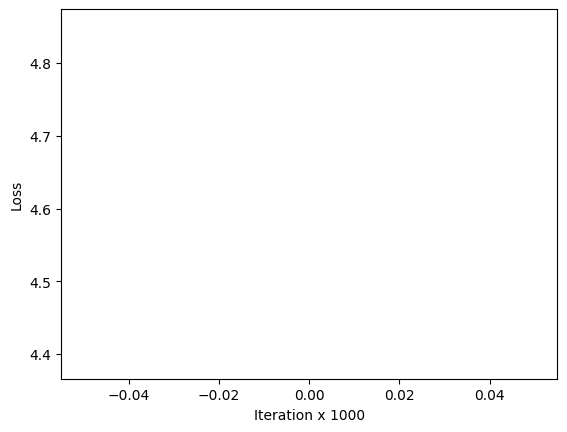

In [97]:
start_time = time.time()

loss_list = []

for iteration in range(NUM_ITER):

    hidden, cell_state = model.init_zero_state()
    optimizer.zero_grad()
    
    loss = 0.
    inputs, targets = draw_random_sample(textfile)
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    
    for c in range(TEXT_PORTION_SIZE):
        outputs, hidden, cell_state = model(inputs[c].unsqueeze(0), hidden, cell_state)
        loss += torch.nn.functional.cross_entropy(outputs, targets[c].view(1))

    loss /= TEXT_PORTION_SIZE
    loss.backward()
    
    ### UPDATE MODEL PARAMETERS
    optimizer.step()

    ### LOGGING
    with torch.no_grad():
        if iteration % 200 == 0:
            print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
            print(f'Iteration {iteration} | Loss {loss.item():.2f}\n\n')
            print(evaluate(model, 'Th', 200), '\n')
            print(50*'=')
            
            loss_list.append(loss.item())
            plt.clf()
            plt.plot(range(len(loss_list)), loss_list)
            plt.ylabel('Loss')
            plt.xlabel('Iteration x 1000')
            plt.savefig('loss1.pdf')
            
plt.clf()
plt.ylabel('Loss')
plt.xlabel('Iteration x 1000')
plt.plot(range(len(loss_list)), loss_list)
plt.show()